# Causal Effect for Logistic Regression

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_prior_knowledge

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.16.2', '0.24.2', '0.11.1', '1.2.0']


## Utility function
We define a utility function to draw the directed acyclic graph.

In [2]:
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=f'{coef:.2f}')
    return d

## Test data
We use 'Wine Quality Data Set' (https://archive.ics.uci.edu/ml/datasets/Wine+Quality)

In [3]:
X = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
X['quality'] = np.where(X['quality']>5, 1, 0)
print(X.shape)
X.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


## Causal Discovery
To run causal discovery, we create a `DirectLiNGAM` object and call the `fit` method.

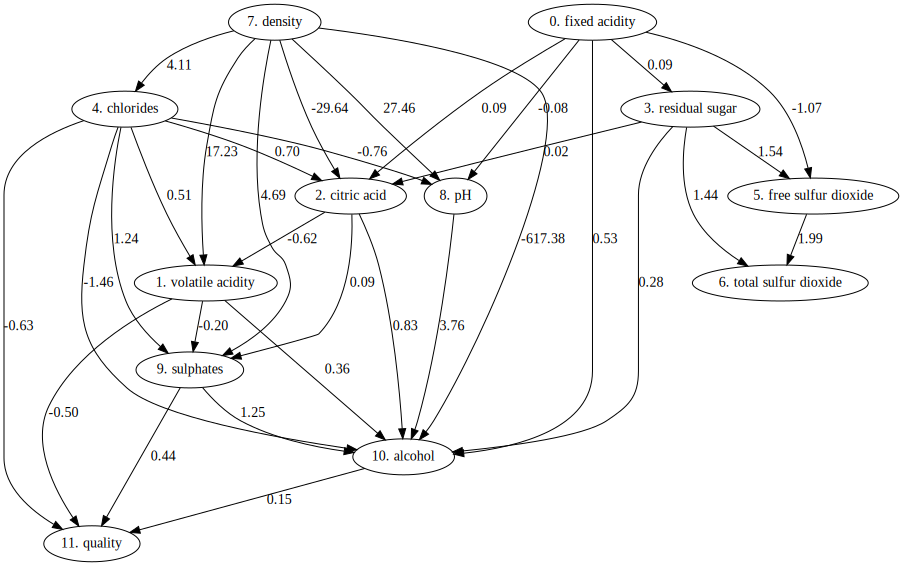

In [4]:
pk = make_prior_knowledge(
    n_variables=len(X.columns),
    sink_variables=[11])

model = lingam.DirectLiNGAM(prior_knowledge=pk)
model.fit(X)
labels = [f'{i}. {col}' for i, col in enumerate(X.columns)]
make_graph(model.adjacency_matrix_, labels)

## Prediction Model
We create the logistic regression model because the target is a discrete variable.

In [5]:
from sklearn.linear_model import LogisticRegression

target = 11 # quality
features = [i for i in range(X.shape[1]) if i != target]
reg = LogisticRegression(solver='liblinear')
reg.fit(X.iloc[:, features], X.iloc[:, target])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

## Identification of Feature with Greatest Causal Influence on Prediction
To identify of the feature having the greatest intervention effect on the prediction, we create a `CausalEffect` object and call the `estimate_effects_on_prediction` method. 

In [6]:
ce = lingam.CausalEffect(model)
effects = ce.estimate_effects_on_prediction(X, target, reg)

df_effects = pd.DataFrame()
df_effects['feature'] = X.columns
df_effects['effect_plus'] = effects[:, 0]
df_effects['effect_minus'] = effects[:, 1]
df_effects

,feature,effect_plus,effect_minus
0,fixed acidity,0.224027,0.224027
1,volatile acidity,0.571723,0.571723
2,citric acid,0.430452,0.430452
3,residual sugar,0.027398,0.027398
4,chlorides,0.027766,0.027766
5,free sulfur dioxide,0.177457,0.177457
6,total sulfur dioxide,0.825355,0.825355
7,density,1.144446,1.144446
8,pH,0.272132,0.272132
9,sulphates,0.516527,0.516527


In [7]:
max_index = np.unravel_index(np.argmax(effects), effects.shape)
print(X.columns[max_index[0]])

density


## Estimation of Optimal Intervention
`estimate_optimal_intervention` method of `CausalEffect` is available only for linear regression models.